## Compare performance of our predictions to that of SLant predictions

Slorth DB: http://slorth.biochem.sussex.ac.uk/  
SLant code: https://bitbucket.org/bioinformatics_lab_sussex/slant/src/master/  
Paper: https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006888

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import sklearn
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import os
import pickle

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 1
%aimport graphing_params

get_data_path = lambda folders, fname: os.path.normpath(os.environ['3RD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+ fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

file_RF_model = get_local_data_path(['results'], 'RF_model.pickle')
file_features = get_local_data_path([], 'feature_list.txt')
file_annot_pairs = get_local_data_path(['processed','paralog_features'], 'all_features.csv')
file_sanger_pairs = get_local_data_path(['processed', 'screen_pairs'], 'sanger_pairs.csv')
file_hart_pairs = get_local_data_path(['processed', 'screen_pairs'], 'hart_pairs.csv')

# From Graeme - full, un-filtered version of the predictions file that is in the Slorth DB
file_slorth_full = get_data_path(['SLant'], 'human_predictions.csv')

### RF Model + all feature annotations + data from independent GI screens

In [9]:
paralog_annot = pd.read_csv(file_annot_pairs)
print('Num annotated pairs:', paralog_annot.shape[0])
paralog_annot[:1]

Num annotated pairs: 36648


,A1,A2,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez,closest,min_sequence_identity,max_sequence_identity,WGD,...,has_cerevisiae_ortholog,has_essential_cerevisiae_ortholog,has_single_essential_cerevisiae_ortholog,has_pombe_ortholog,has_essential_pombe_ortholog,has_single_essential_pombe_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc
0,A1BG,OSCAR,ENSG00000121410,ENSG00000170909,1,126014,False,0.127273,0.22028,False,...,False,False,False,False,False,False,3,210.95,0.0,False


In [11]:
all_sanger_pairs = pd.read_csv(file_sanger_pairs)
all_sanger_pairs = pd.merge(all_sanger_pairs, paralog_annot)
all_sanger_pairs['SL'] = all_sanger_pairs.n_SL >= 1
print('All:', sum(all_sanger_pairs.SL), '/', all_sanger_pairs.shape[0])
all_sanger_pairs[:2]

All: 71 / 541


,index,A1,A2,GENE PAIR,A375_SL,Mewo_SL,RPE_SL,n_SL,passes_min_1_filter,passes_A375_filter,...,has_essential_cerevisiae_ortholog,has_single_essential_cerevisiae_ortholog,has_pombe_ortholog,has_essential_pombe_ortholog,has_single_essential_pombe_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc,SL
0,0,CASKIN1,CASKIN2,CASKIN1_CASKIN2,False,False,False,0,True,True,...,False,False,False,False,False,6,842.0,0.0,False,False
1,1,MIB1,MIB2,MIB2_MIB1,False,False,False,0,True,True,...,False,False,False,False,False,5,842.0,0.0,False,False


In [12]:
all_hart_pairs = pd.read_csv(file_hart_pairs)
all_hart_pairs = pd.merge(all_hart_pairs, paralog_annot)
all_hart_pairs['SL'] = all_hart_pairs.n_SL >= 1
print('All:', sum(all_hart_pairs.SL), '/', all_hart_pairs.shape[0])
all_hart_pairs[:1]

All: 24 / 393


,A1,A2,min_seq_id,pair,A549,HT29,OVCAR8,A549_SL,HT29_SL,OVCAR8_SL,...,has_essential_cerevisiae_ortholog,has_single_essential_cerevisiae_ortholog,has_pombe_ortholog,has_essential_pombe_ortholog,has_single_essential_pombe_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc,SL
0,SRSF4,SRSF5,0.346154,SRSF4_SRSF5,0.281,0.04,0.853,False,False,False,...,True,True,True,True,False,7,911.3,0.0,False,False


In [13]:
feature_list = pd.read_csv(file_features)
features = list(feature_list[feature_list.include==1].feature)
print('N features:', len(features))

N features: 22


In [6]:
with open(file_RF_model, 'rb') as f:
    RF = pickle.load(f)

### Load SLant Predictions

In [7]:
slant_preds = pd.read_csv(file_slorth_full, sep=' ')

In [14]:
print('N pairs:', slant_preds.shape[0])
slant_preds[:1]

N pairs: 6455807


,human,yeast,worm,fly,pombe,consensus,gene1,gene2
1,0.556139,0.471423,0.424513,0.44521,0.445521,0.539792,ENSG00000004897,ENSG00000006715


### Graphing functions

In [33]:
slant_color = '#7b07a8'

def draw_roc_curve(data, ypred, ax, label='', color='black', w_seq=True, w_chance=True):
    fpr, tpr, _ = roc_curve(data.SL, ypred)
    ax.step(fpr, tpr, label=label+'(%.2f) ' % (auc(fpr, tpr)), color=color, zorder=10)    
    if w_seq:
        fpr_seq_id, tpr_seq_id, _ = roc_curve(data.SL, data.min_sequence_identity)
        ax.step(fpr_seq_id, tpr_seq_id, label='Seq. Id. (%.2f) ' % (auc(fpr_seq_id, tpr_seq_id)), color='#E69F00')
    if w_chance:
        ax.plot([0, 1], [0, 1], linestyle='--', color='black', lw=mpl.rcParams['lines.linewidth'], label='Chance (0.50)')
        ax.legend(loc="lower right", bbox_to_anchor=(1.08,-0.03)) 
    ax.set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')
    ax.set_ylim([-0.05,1.02]); ax.set_xlim([-0.05,1.02])

    
def draw_pr_curve(data, ypred, ax, label='', color='black', w_seq=True, w_chance=True, trim=False):
    precision, recall, _ = precision_recall_curve(data.SL, ypred)
    if trim: precision = precision[:-1]; recall = recall[:-1]
    avg_precision = average_precision_score(data.SL, ypred)
    line_kwargs = {"drawstyle": "steps-post"}
    ax.plot(recall, precision, label=label+'(%.2f) ' % (avg_precision), color=color, **line_kwargs, zorder=10)
    
    if w_seq:
        precision_seq_id, recall_seq_id, _ = precision_recall_curve(data.SL, data.min_sequence_identity)
        recall_seq_id = recall_seq_id[:-1]; precision_seq_id = precision_seq_id[:-1]
        ap_seq_id = average_precision_score(data.SL,  data.min_sequence_identity)
        ax.plot(recall_seq_id, precision_seq_id, label='Seq. Id. (%.2f) ' % (ap_seq_id), color='#E69F00', **line_kwargs)
    if w_chance:
        no_skill = sum(data.SL) / (data.SL).count()
        ax.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='Chance (%.2f)' % (no_skill),
                lw=mpl.rcParams['lines.linewidth']-0.2)
        ax.legend(loc="upper right", bbox_to_anchor=(1.1,1))
    ax.set_xlabel('Recall'); ax.set_ylabel('Precision')
    ax.set_ylim([-0.05,1.02]); ax.set_xlim([-0.05,1.02])
    

def draw_curves(testing_data, ypred, ax, screen, n_SL):
    draw_roc_curve(testing_data, ypred, ax[0], label='RF ', w_seq=False, w_chance=False)
    draw_roc_curve(testing_data, testing_data.consensus, ax[0], label='SLant ', color=slant_color)
    draw_pr_curve(testing_data, ypred, ax[1], label='RF ', w_seq=False, w_chance=False, trim=True)
    draw_pr_curve(testing_data, testing_data.consensus, ax[1], label='SLant ', color=slant_color)
    f.suptitle(screen+' screens, SL in '+n_SL+
               ' cell lines (SL='+str(sum(testing_data.SL))+', non-SL='+str(sum(~testing_data.SL))+')', 
               fontsize=9, fontweight='bold', horizontalalignment='center')

### Predicting results from Thompson et al. with SLant consensus scores

In [23]:
# Merge with Sanger pairs
df1 = pd.merge(slant_preds.rename(columns={'gene1':'A2_ensembl','gene2':'A1_ensembl'}), all_sanger_pairs)
df2 = pd.merge(slant_preds.rename(columns={'gene1':'A1_ensembl','gene2':'A2_ensembl'}), all_sanger_pairs)
slant_sanger_overlap = pd.concat([df1, df2])
print('N SLANT-Sanger overlap:', slant_sanger_overlap.shape[0])
slant_sanger_overlap[:1]

N SLANT-Sanger overlap: 161


,human,yeast,worm,fly,pombe,consensus,A2_ensembl,A1_ensembl,index,A1,...,has_essential_cerevisiae_ortholog,has_single_essential_cerevisiae_ortholog,has_pombe_ortholog,has_essential_pombe_ortholog,has_single_essential_pombe_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc,SL
0,0.915645,0.76457,0.507076,0.835795,0.699656,0.883604,ENSG00000013503,ENSG00000047315,279,POLR2B,...,True,True,True,True,False,9,4200.0,0.0,False,False


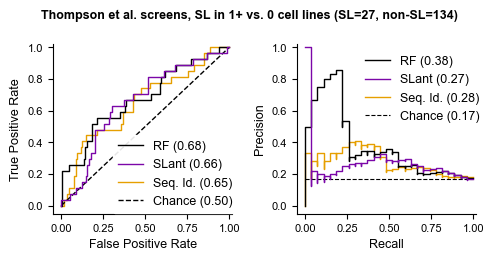

In [35]:
# Distinguishing pairs SL in 1+ vs. 0 cell lines
testing_data = slant_sanger_overlap
ypred = RF.predict_proba(testing_data[features])[:,1]

f, ax = plt.subplots(1, 2, figsize=(5.05,2.6))
draw_curves(testing_data, ypred, ax, 'Thompson et al.', '1+ vs. 0')
plt.tight_layout()
#f.savefig("../figures/for_paper/slant_curves_sanger_1+.svg", dpi=300, bbox_inches="tight")

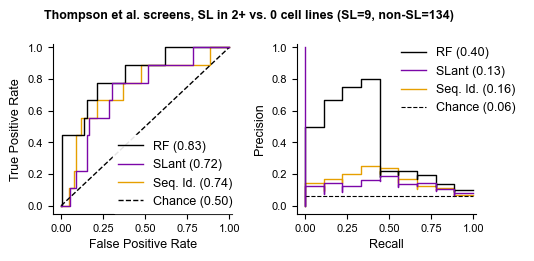

In [38]:
# Distinguishing pairs SL in  2-3 vs. 0 cell lines
testing_data = slant_sanger_overlap[slant_sanger_overlap.n_SL!=1].reset_index(drop=True)
ypred = RF.predict_proba(testing_data[features])[:,1]

f, ax = plt.subplots(1, 2, figsize=(5.05,2.6))
draw_curves(testing_data, ypred, ax, 'Thompson et al.', '2+ vs. 0')
plt.tight_layout()
ax[1].legend(loc="upper right", bbox_to_anchor=(1.3,1.05))
#f.savefig("../figures/for_paper/slant_curves_sanger_2+.svg", dpi=300, bbox_inches="tight")

### Predicting results from Dede et al. with SLant consensus scores

In [25]:
# Merge with Sanger pairs
df1 = pd.merge(slant_preds.rename(columns={'gene1':'A2_ensembl','gene2':'A1_ensembl'}), all_hart_pairs)
df2 = pd.merge(slant_preds.rename(columns={'gene1':'A1_ensembl','gene2':'A2_ensembl'}), all_hart_pairs)
slant_hart_overlap = pd.concat([df1, df2])
print('N SLANT-Hart overlap:', slant_hart_overlap.shape[0])
slant_hart_overlap[:1]

N SLANT-Hart overlap: 131


,human,yeast,worm,fly,pombe,consensus,A2_ensembl,A1_ensembl,A1,A2,...,has_essential_cerevisiae_ortholog,has_single_essential_cerevisiae_ortholog,has_pombe_ortholog,has_essential_pombe_ortholog,has_single_essential_pombe_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc,SL
0,0.802051,0.805347,0.660383,0.975294,0.736738,0.86579,ENSG00000049618,ENSG00000117713,ARID1A,ARID1B,...,False,False,True,False,False,6,842.0,1.0,True,False


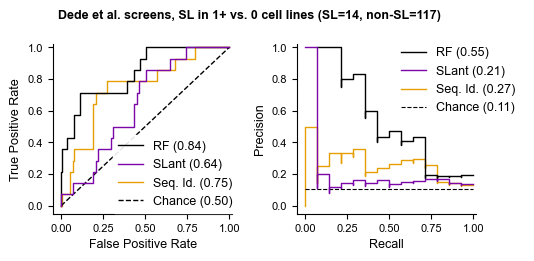

In [39]:
# Distinguishing pairs SL in 1+ vs. 0 cell lines
testing_data = slant_hart_overlap
ypred = RF.predict_proba(testing_data[features])[:,1]

f, ax = plt.subplots(1, 2, figsize=(5.05,2.6))
draw_curves(testing_data, ypred, ax, 'Dede et al.', '1+ vs. 0')
plt.tight_layout()
ax[1].legend(loc="upper right", bbox_to_anchor=(1.3,1.05))
#f.savefig("../figures/for_paper/slant_curves_hart_1+.svg", dpi=300, bbox_inches="tight")

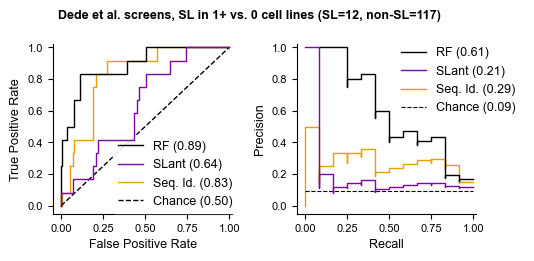

In [40]:
# Distinguishing pairs SL in 2+ vs. 0 cell lines
testing_data = slant_hart_overlap[slant_hart_overlap.n_SL!=1].reset_index(drop=True)
ypred = RF.predict_proba(testing_data[features])[:,1]

f, ax = plt.subplots(1, 2, figsize=(5.05,2.6))
draw_curves(testing_data, ypred, ax, 'Dede et al.', '1+ vs. 0')
plt.tight_layout()
ax[1].legend(loc="upper right", bbox_to_anchor=(1.3,1.05))
#f.savefig("../figures/for_paper/slant_curves_hart_2+.svg",dpi=300, bbox_inches="tight")